# LSTM
In this notebook the LSTM model will be implemented. We will use historical energy consumption data and meteorological data to make a prediction on future consumption values.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

seed=99
random.seed(seed)
np.random.seed(seed)

In [40]:
# Check for TensorFlow GPU access
print(tf.config.list_physical_devices())
# See TensorFlow version
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
2.16.1


In [11]:
morocco = pd.read_csv("../data/processed/morocco_processed.csv")

In [19]:
# Set up data
morocco = pd.read_csv("../data/processed/morocco_processed.csv")
usa = pd.read_csv("../data/raw/usa.csv")
paraguay = pd.read_csv("../data/raw/paraguay.csv")
#spain_cities_average = pd.read_csv('spain_cities_average.csv')
#barcelona = pd.read_csv('spain_cities_barcelona.csv')
#bilbao = pd.read_csv('spain_cities_bilbao.csv')
#madrid = pd.read_csv('spain_cities_madrid.csv')
#seville = pd.read_csv('spain_cities_seville.csv')
#valencia = pd.read_csv('spain_cities_valencia.csv')
#spain_houses = pd.read_csv('spain_houses.csv')

# remove missing data from end of datasets since we cant linear interpolate it
usa = usa.iloc[:-18]
paraguay = paraguay.iloc[:-360]
datasets = {'morocco': morocco, 'paraguay': paraguay, 'usa': usa}
datasets_electricity = {'morocco': morocco, 'paraguay': paraguay, 'usa': usa}

# convert DateTime column to datetime
for dataset in datasets:
    if dataset in ['spain_cities_average', 'barcelona', 'bilbao', 'madrid', 'seville', 'valencia', 'spain_houses']:
        datasets[dataset]['DateTime'] = pd.to_datetime(datasets[dataset]['DateTime'], utc=True)
    else:
        datasets[dataset]['DateTime'] = pd.to_datetime(datasets[dataset]['DateTime'])

# Consumption will never be zero, so mark that as missing data
for dataset_name in datasets:
    datasets[dataset_name].loc[datasets[dataset_name]['Consumption'] == 0, 'Consumption'] = np.nan

# Something is wrong with the "Spain houses" data, so set consumption values above 2000 to missing
#datasets['spain_houses'].loc[datasets['spain_houses']['Consumption'] > 2000, 'Consumption'] = np.nan

#print(spain_houses.describe())
# Fill missing data with simple linear interpolation
for dataset_name in datasets:
    datasets[dataset_name][["Consumption", "Temperature"]] = datasets[dataset_name][["Consumption", "Temperature"]].interpolate(method='cubic')

#print(spain_houses.describe())

In [20]:
for dataset_name in datasets_electricity:
    dataset = datasets[dataset_name]
    print(dataset_name)
    print(dataset.isna().sum())
    print()

morocco
DateTime                 0
Consumption              0
Temperature              0
Humidity                 0
Wind Speed               0
general diffuse flows    0
diffuse flows            0
dtype: int64

paraguay
DateTime       0
Consumption    0
Temperature    0
dtype: int64

usa
DateTime       0
Consumption    0
Temperature    0
dtype: int64



In [110]:
# Feature functions
# augment_time_series
# add_time_features
# add_lagged_timesteps
# add_target_without_cyclicality
# add_moving_mean
# upsample_timeseries

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

def add_lagged_timesteps(input_df, lag_periods=[1,2,3,24], lagged_feature='Consumption'):
    # Add lagged timesteps of a feature
    df = input_df.copy()
    for lag_period in lag_periods:
        df['lagged_' + lagged_feature + "_" + str(lag_period)] = df[lagged_feature].shift(lag_period)
    return df

def add_time_features(input_df):
    # Sin and cos encoding of time features
    df = input_df.copy()
    df['hour_of_day_sin'] = np.sin(2 * np.pi * df['DateTime'].dt.hour / 24)
    df['hour_of_day_cos'] = np.cos(2 * np.pi * df['DateTime'].dt.hour / 24)

    df['day_of_week_sin'] = np.sin(2 * np.pi * df['DateTime'].dt.dayofweek / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['DateTime'].dt.dayofweek / 7)

    df['day_of_year_sin'] = np.sin(2 * np.pi * df['DateTime'].dt.dayofyear / 365)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['DateTime'].dt.dayofyear / 365)
    return df

In [ ]:
# Add autocorrelation of steps: add lagged features, ridge regression fitting and evaluation
# MAPE for different lookback horizons with Ridge Regression: Not much difference between 48, 168, 336
# MAPE for different hyperparameters with Ridge Regression: no difference for alpha values
# MAPE for different features with Ridge Regression:
# - almost no diff between 48 steps and lag temp+ time encoding
# - almost no diff 48 steps, target without cyclicality, moving mean feature, granger causality feature, added data augmentation

# MAPE for different hyperparameters with LGBM: more difference, but not enough for me to care: estimators, leaves
# MAPE of LGBMRegressor with different hyperparameters predicting Consumption: same as above
# MAPE for weather features with LGBM: no diff between 48-steps and lagged temp + time encoding
# MAPE for different lookback horizons with LGBM: no diff 48, 169, 336
# MAPE of different features predicting Consumption with LGBRegressor: not much diff
# MAPE for different features with LGBM: not that much

# MAPE for different hyperparameters with LSTM: lookback [6, 12, 24], layers [1,2].
# - They generally performed the same. 24 hrs 2 layers did worst for spain houses and usa dataset. I should test this

# BiLSTM

# Transformer v2

In [12]:
#morocco.set_index('DateTime', inplace=True)

In [13]:
display(morocco.head())
print('null values:', morocco.isnull().sum().sum())
print()
print('data types:', morocco.dtypes)

,Consumption,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows
DateTime,,,,,,
2017-01-01 00:00:00,398860.62358,6.196833,75.066667,0.081833,0.063500,0.098833
2017-01-01 01:00:00,346671.15726,5.548833,77.583333,0.082000,0.056833,0.112500
2017-01-01 02:00:00,312539.28984,5.054333,78.933333,0.082333,0.063000,0.129167
2017-01-01 03:00:00,293486.68529,5.004333,77.083333,0.082833,0.059833,0.141000
2017-01-01 04:00:00,286287.83008,5.097667,74.050000,0.082333,0.058000,0.122833


null values: 0

data types: Consumption              float64
Temperature              float64
Humidity                 float64
Wind Speed               float64
general diffuse flows    float64
diffuse flows            float64
dtype: object


In [ ]:
# Print feature importances
for i, dataset_name in enumerate(datasets_electricity):
    print(f"\nFeature importances for {dataset_name}:")
    for feature, importance in feature_importances_list[i][:7]:
        print(f"{feature}: {importance}")

### Literature review
In the previous thesis written by Andreas:  
* Scikit StandardScaler
* 48h lookback horizon
* Hyperparameter tuning on lookback horizon and number of layers using grid search.
* The parameters to adjust was selected so that the training would use less than 12h on a NVIDIA P100 graphics card.
* Did not use cross-validation given time series data. Instead used train-test split using the last 90 days for test. This makes sense, and is kinda how I selected my data.
* Batch size 32, max 150 epochs, learning rate schedulers on plateau, initial lr=0.001

## Split data into training and test sets
The Morocco dataset contains one year of data of 10 min granularity. In order to respect the temporal order of observations we'll split on a given timestep and use the data before the respective timestamp as training data and the data after will be used for testing.

In [1]:
if False:
    split_date = pd.Timestamp('2017-12-01')

    train = morocco[(morocco['month'] < 12)]
    test = morocco[(morocco['month'] >= 12)]

    X_train = train.drop(columns=['Consumption'])
    y_train = train['Consumption']

    X_test = test.drop(columns=['Consumption'])
    y_test = test['Consumption']
    
    print('X_train:', X_train.shape)
    print('y_train:', y_train.shape)

### Tensorflow implementation
You should have your data split into input sequences (X) and the corresponding labels (y). Here, X is expected to be a 3D array of shape (number of samples, time steps, features per step), and y is a 2D array of shape (number of samples, target variable).

Replace 50 with the number of LSTM units you want. The input_shape parameter should match the shape of your input data, excluding the sample dimension (e.g., (time steps, features per step)).

Here, X.shape[1] is the number of time steps, and X.shape[2] is the number of features per time step. Adjust the epochs and validation_split as necessary.

Assuming X_test is your test dataset prepared in the same way as your training dataset (X).

Remember, the effectiveness of your model heavily depends on the quality of your data, the way you've preprocessed it, and the hyperparameters of the model. It's often beneficial to experiment with different configurations, LSTM layers, and maybe adding dropout layers to improve the model's performance and prevent overfitting.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

The LSTM model is defined with input_shape=(n_steps, n_features), which expects 3-dimensional input. Cannot directly pass X_train and y_train to the models fit() function without reshaping them to include the time steps dimension. You need to reshape your `X_train` and `X_test` data into the 3-dimensional shape expected by the LSTM layers. This is typically done by segmenting your time series data into sequences.  

Tensorflow introduces TimeseriesGenerator, which automatically handle the segmentation of time series data into (samples, time steps, features) format that LSTM layers expect.

In [ ]:
# Timeseriesgenerator is deprecated. Here is the manual code.
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

n_steps = lookback  # time steps parameter
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled.flatten(), n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled.flatten(), n_steps)

Selecting the window size/ n_steps. Pick one that allows the model to learn long-term dependencies, but hyptuning isn't neccessary. We perform short term forecasting, so we will use 2 days = 48 hours.

In [112]:
# Learning rate scheduler, adjusting the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    elif epoch%10==0:
        return lr * tf.math.exp(-0.3)
    else:
        return lr

# Defines the LSTM model
def lstm_model(train_generator, test_generator, n_steps, n_features, n_epochs, n_layers):
    model = Sequential()
    for _ in range(n_layers - 1):
        model.add(LSTM(
            # LSTM units = 32
            # input shape = (X.shape[1], X.shape[2])
            32, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)
    ))
    
    model.add(LSTM(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate = 0.001), loss='mse')
    
    # Set up the learning rate scheduler
    callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)]
    
    #model.fit(X, y, epochs=20, validation_split=0.2, verbose=1)
    model.fit(train_generator, epochs=n_epochs, verbose=0, validation_data=test_generator)#, callbacks=callbacks)
    #model.fit(X_train, y_train, epochs=n_epochs, verbose=1, callbacks=callbacks)
    return model

def lstm_fitting_and_evaluation(features, target, dataset_name, model_file_identifier='_', lookback = 6, n_layers = 2):
    # split_and_scale: Test set is the last 90 days
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=2160, random_state=seed, shuffle=False)
    
    # Scale X data
    XScaler = StandardScaler()
    XScaler.fit(X_train)
    scaled_X_train = XScaler.transform(X_train)
    scaled_X_test = XScaler.transform(X_test)

    # Scale Y data
    YScaler = StandardScaler()
    YScaler.fit(y_train.values.reshape(-1, 1))
    scaled_y_train = YScaler.transform(y_train.values.reshape(-1, 1))
    scaled_y_test = YScaler.transform(y_test.values.reshape(-1, 1))
    
    # Variables
    n_steps = lookback # Hours to look back
    batch = 64
    epochs = 150
    
    # Generate sequences to learn on
    generator_train = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_steps, batch_size=batch)
    generator_test = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=n_steps, batch_size=batch)
    
    
    model_file_path = "lstm/" + model_file_identifier + "/" + dataset_name
    try: # Try to load the model if it already exists
        model = tf.keras.models.load_model(model_file_path)
    except: # If it doesn't exist, train the model and save it
        n_features = X_train.shape[1]
        #model = create_lstm_model(X_train, X_test, y_train, y_test, n_steps, n_features, epochs, n_layers)
        model = lstm_model(generator_train, generator_test, n_steps, n_features, epochs, n_layers)
        #model.save(model_file_path)
        #tf.saved_model.save()
    
    # evaluate the model on the test set
    y_pred_scaled = model.predict(generator_test)
    y_pred = YScaler.inverse_transform(y_pred_scaled)
    mape = mean_absolute_percentage_error(y_test[n_steps:], y_pred)
    mae = mean_absolute_error(y_test[n_steps:], y_pred)
    r2 = r2_score(y_test[n_steps:], y_pred)
    print(f'{dataset_name}, MAE: {mae:.2f}, MAPE: {mape:.3f}, R2: {r2:.3f}')
    
    # Calculate aic and bic values
    # Compute AIC and BIC for SVM model
    n = len(y_test)
    k = X_train.shape[1] + 1  # Number of parameters including intercept
    log_likelihood = -0.5 * n * np.log(2 * np.pi * mae) - n * np.log(mae)  # Assuming normal distribution for errors
    aic_value = 2 * k - 2 * log_likelihood
    bic_value = np.log(n) * k - 2 * log_likelihood
    print(f'LSTM Model - AIC: {aic_value:.2f}, BIC: {bic_value:.2f}')

    return r2, mae, mape, aic_value, bic_value

In [ ]:
%%time
lstm_fitting_and_evaluation(data.drop(columns=['DateTime', 'Consumption', 'Temperature']), data['Consumption'], dataset_name, model_file_identifier=str(lookback) + "_" + str(n_layers), lookback=lookback, n_layers=n_layers)

### Hyperparameter tuning
The results from Andreas confused me, so test it out.

[ ] MAPE for different hyperparameters with LSTM: different lookback horizons and layers  
[ ] MAPE for weather features with LSTM  
[ ] MAPE for different features with LSTM (baseline, some other stuff)  
[ ] MAPE for different lookback horizons with LSTM (48, 168, 336)  

In [46]:
%%time
# Tuning done on 50 epochs 48 lagged steps
hyperparameter_tuning = {}
for lookback in [6, 12, 24]:
    for n_layers in [1, 2]:
        print(f'Hyperparameters: lookback={lookback}, n_layers={n_layers}')
        parameter_results = []
        for dataset_name in datasets_electricity:
            start_time = time.time()
            
            data = add_lagged_timesteps(datasets[dataset_name], lag_periods=[i for i in range(1, 49)], lagged_feature='Consumption').dropna().reset_index(drop=True)
            r2, mae, mape, aic_value, bic_value = lstm_fitting_and_evaluation(data.drop(columns=['DateTime', 'Consumption', 'Temperature']), data['Consumption'], dataset_name, model_file_identifier=str(lookback) + "_" + str(n_layers), lookback=lookback, n_layers=n_layers)
            parameter_results.append(aic_value)
            
            end_time = time.time()
            print(f"Time taken: {end_time - start_time:.2f} seconds")
            
        hyperparameter_tuning["Lookback:"+str(lookback) + ' ' + "Layers:"+str(n_layers)] = parameter_results


Hyperparameters: lookback=6, n_layers=1
Epoch 1/150
 74/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0961  

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9043 - val_loss: 0.0613
Epoch 2/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0611 - val_loss: 0.0495
Epoch 3/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0474 - val_loss: 0.0489
Epoch 4/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0412 - val_loss: 0.0294
Epoch 5/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0298 - val_loss: 0.0296
Epoch 6/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0284 - val_loss: 0.0229
Epoch 7/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0224 - val_loss: 0.0235
Epoch 8/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0341 - val_loss: 0.0217
Epoch 9/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0800 - val_loss: 0.0176
Epoch 10/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0202 - val_loss: 0.0175
Epoch 11/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0192 - val_loss: 0.0144
Epoch 12/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0073 - val_loss: 0.0077
Epoch 69/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 - val_loss: 0.0077
Epoch 70/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 71/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0067 - val_loss: 0.0094
Epoch 72/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078 - val_loss: 0.0085
Epoch 73/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 74/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - val_loss: 0.0094
Epoch 75/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0073 - val_loss: 0.0107
Epoch 76/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0084
Epoch 77/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0074 - val_loss: 0.0098
Epoch 78/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 79/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 135/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0091
Epoch 136/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0085
Epoch 137/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050 - val_loss: 0.0105
Epoch 138/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062 - val_loss: 0.0091
Epoch 139/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0061 - val_loss: 0.0093
Epoch 140/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0048 - val_loss: 0.0092
Epoch 141/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 - val_loss: 0.0114
Epoch 142/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043 - val_loss: 0.0087
Epoch 143/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0047 - val_loss: 0.0102
Epoch 144/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0048 - val_loss: 0.0119
Epoch 145/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - val_loss: 0.0093
Epoch 146/150
102/102

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3014 - val_loss: 0.0802
Epoch 2/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0717 - val_loss: 0.0620
Epoch 3/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0617 - val_loss: 0.0485
Epoch 4/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0436 - val_loss: 0.0429
Epoch 5/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0394 - val_loss: 0.0383
Epoch 6/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0362 - val_loss: 0.0364
Epoch 7/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0395 - val_loss: 0.0354
Epoch 8/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0347 - val_loss: 0.0334
Epoch 9/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0292 - val_loss: 0.0321
Epoch 10/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0361 - val_loss: 0.0347
Epoch 11/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0316 - val_loss: 0.0425
Epoch 12/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0195 - val_loss: 0.0295
Epoch 69/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0197 - val_loss: 0.0284
Epoch 70/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0194 - val_loss: 0.0292
Epoch 71/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0190 - val_loss: 0.0302
Epoch 72/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0196 - val_loss: 0.0295
Epoch 73/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0197 - val_loss: 0.0303
Epoch 74/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0187 - val_loss: 0.0284
Epoch 75/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0188 - val_loss: 0.0295
Epoch 76/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0195 - val_loss: 0.0331
Epoch 77/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0196 - val_loss: 0.0286
Epoch 78/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0187 - val_loss: 0.0291
Epoch 79/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0164 - val_loss: 0.0303
Epoch 136/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0159 - val_loss: 0.0309
Epoch 137/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0158 - val_loss: 0.0297
Epoch 138/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0159 - val_loss: 0.0298
Epoch 139/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0175 - val_loss: 0.0314
Epoch 140/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0159 - val_loss: 0.0313
Epoch 141/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0155 - val_loss: 0.0313
Epoch 142/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0163 - val_loss: 0.0308
Epoch 143/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0155 - val_loss: 0.0303
Epoch 144/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0158 - val_loss: 0.0313
Epoch 145/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0157 - val_loss: 0.0297
Epoch 146/150
508/508

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3345 - val_loss: 0.0578
Epoch 2/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1969 - val_loss: 0.0476
Epoch 3/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0643 - val_loss: 0.0384
Epoch 4/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0488 - val_loss: 0.0439
Epoch 5/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0409 - val_loss: 0.0282
Epoch 6/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0656 - val_loss: 0.0322
Epoch 7/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0416 - val_loss: 0.0240
Epoch 8/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0420 - val_loss: 0.0282
Epoch 9/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0563 - val_loss: 0.0283
Epoch 10/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1692 - val_loss: 0.0262
Epoch 11/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0894 - val_loss: 0.0434
Epoch 12/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0123
Epoch 69/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0138 - val_loss: 0.0121
Epoch 70/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0288 - val_loss: 0.0203
Epoch 71/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0332 - val_loss: 0.0207
Epoch 72/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0518 - val_loss: 0.0128
Epoch 73/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0156 - val_loss: 0.0124
Epoch 74/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0158 - val_loss: 0.0122
Epoch 75/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0148 - val_loss: 0.0121
Epoch 76/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0122 - val_loss: 0.0114
Epoch 77/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 78/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0197 - val_loss: 0.0122
Epoch 79/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0199 - val_loss: 0.0123
Epoch 136/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0143 - val_loss: 0.0117
Epoch 137/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0524 - val_loss: 0.0120
Epoch 138/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0124 - val_loss: 0.0133
Epoch 139/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0134 - val_loss: 0.0111
Epoch 140/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0132 - val_loss: 0.0115
Epoch 141/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0135 - val_loss: 0.0120
Epoch 142/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0151 - val_loss: 0.0140
Epoch 143/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0252 - val_loss: 0.0116
Epoch 144/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0273 - val_loss: 0.0114
Epoch 145/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0236 - val_loss: 0.0129
Epoch 146/150
582/582

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 65/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6071  

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5060 - val_loss: 0.0637
Epoch 2/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0776 - val_loss: 0.0576
Epoch 3/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513 - val_loss: 0.0579
Epoch 4/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0432 - val_loss: 0.0422
Epoch 5/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0457 - val_loss: 0.0499
Epoch 6/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356 - val_loss: 0.0306
Epoch 7/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0409 - val_loss: 0.0417
Epoch 8/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0378 - val_loss: 0.0241
Epoch 9/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304 - val_loss: 0.0286
Epoch 10/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - val_loss: 0.0306
Epoch 11/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307 - val_loss: 0.0358
Epoch 12/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0105
Epoch 69/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0110
Epoch 70/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0087
Epoch 71/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0116
Epoch 72/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0083
Epoch 73/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0109
Epoch 74/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0084
Epoch 75/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 0.0104
Epoch 76/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063 - val_loss: 0.0089
Epoch 77/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0105
Epoch 78/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0077
Epoch 79/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 135/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0083
Epoch 136/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0099
Epoch 137/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0086
Epoch 138/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - val_loss: 0.0088
Epoch 139/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048 - val_loss: 0.0077
Epoch 140/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - val_loss: 0.0073
Epoch 141/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0095
Epoch 142/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 - val_loss: 0.0122
Epoch 143/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0050 - val_loss: 0.0087
Epoch 144/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0094
Epoch 145/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0057 - val_loss: 0.0085
Epoch 146/150
102/102

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 67/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8510

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3787 - val_loss: 0.1133
Epoch 2/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1118 - val_loss: 0.0763
Epoch 3/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0744 - val_loss: 0.0591
Epoch 4/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0592 - val_loss: 0.0562
Epoch 5/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0493 - val_loss: 0.0417
Epoch 6/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0426 - val_loss: 0.0385
Epoch 7/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0392 - val_loss: 0.0422
Epoch 8/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0364 - val_loss: 0.0351
Epoch 9/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0337 - val_loss: 0.0373
Epoch 10/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0367 - val_loss: 0.0345
Epoch 11/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0320 - val_loss: 0.0374
Epoch 12/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0188 - val_loss: 0.0282
Epoch 69/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0172 - val_loss: 0.0290
Epoch 70/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174 - val_loss: 0.0286
Epoch 71/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0182 - val_loss: 0.0278
Epoch 72/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0183 - val_loss: 0.0288
Epoch 73/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0179 - val_loss: 0.0275
Epoch 74/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0169 - val_loss: 0.0289
Epoch 75/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0172 - val_loss: 0.0282
Epoch 76/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0171 - val_loss: 0.0298
Epoch 77/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0166 - val_loss: 0.0284
Epoch 78/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0176 - val_loss: 0.0314
Epoch 79/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0132 - val_loss: 0.0322
Epoch 136/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0123 - val_loss: 0.0323
Epoch 137/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0131 - val_loss: 0.0353
Epoch 138/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0130 - val_loss: 0.0305
Epoch 139/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0131 - val_loss: 0.0303
Epoch 140/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0315
Epoch 141/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - val_loss: 0.0314
Epoch 142/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0126 - val_loss: 0.0303
Epoch 143/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0121 - val_loss: 0.0322
Epoch 144/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0129 - val_loss: 0.0310
Epoch 145/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0124 - val_loss: 0.0323
Epoch 146/150
508/508

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 67/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4873

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5120 - val_loss: 0.0880
Epoch 2/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2086 - val_loss: 0.0532
Epoch 3/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1328 - val_loss: 0.0478
Epoch 4/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0880 - val_loss: 0.0472
Epoch 5/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0670 - val_loss: 0.0414
Epoch 6/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1147 - val_loss: 0.0404
Epoch 7/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4293 - val_loss: 0.0538
Epoch 8/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3512 - val_loss: 0.0499
Epoch 9/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0919 - val_loss: 0.0704
Epoch 10/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1718 - val_loss: 0.0328
Epoch 11/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1397 - val_loss: 0.0299
Epoch 12/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0360 - val_loss: 0.0521
Epoch 69/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1176 - val_loss: 0.0173
Epoch 70/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0329 - val_loss: 0.0154
Epoch 71/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0295 - val_loss: 0.0146
Epoch 72/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0217 - val_loss: 0.0148
Epoch 73/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0188 - val_loss: 0.0139
Epoch 74/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0165 - val_loss: 0.0131
Epoch 75/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0174 - val_loss: 0.0124
Epoch 76/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - val_loss: 0.0146
Epoch 77/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0254 - val_loss: 0.0151
Epoch 78/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0388 - val_loss: 0.0125
Epoch 79/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0222 - val_loss: 0.0114
Epoch 136/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - val_loss: 0.0109
Epoch 137/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0310 - val_loss: 0.0110
Epoch 138/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - val_loss: 0.0109
Epoch 139/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0148 - val_loss: 0.0111
Epoch 140/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 141/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0688 - val_loss: 0.0146
Epoch 142/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0767 - val_loss: 0.0125
Epoch 143/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0147 - val_loss: 0.0122
Epoch 144/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0115
Epoch 145/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0183 - val_loss: 0.0116
Epoch 146/150
582/582

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3313 - val_loss: 0.0607
Epoch 2/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0553 - val_loss: 0.0392
Epoch 3/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461 - val_loss: 0.0298
Epoch 4/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0373 - val_loss: 0.0661
Epoch 5/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0299 - val_loss: 0.0243
Epoch 6/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0282 - val_loss: 0.0203
Epoch 7/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0262 - val_loss: 0.0241
Epoch 8/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223 - val_loss: 0.0196
Epoch 9/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0159
Epoch 10/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - val_loss: 0.0167
Epoch 11/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - val_loss: 0.0152
Epoch 12/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 69/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0076
Epoch 70/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - val_loss: 0.0094
Epoch 71/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0084
Epoch 72/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 73/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0070 - val_loss: 0.0117
Epoch 74/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0110
Epoch 75/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 76/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0081
Epoch 77/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - val_loss: 0.0119
Epoch 78/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0134
Epoch 79/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 135/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056 - val_loss: 0.0135
Epoch 136/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046 - val_loss: 0.0104
Epoch 137/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - val_loss: 0.0119
Epoch 138/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.0093
Epoch 139/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049 - val_loss: 0.0162
Epoch 140/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062 - val_loss: 0.0080
Epoch 141/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - val_loss: 0.0106
Epoch 142/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060 - val_loss: 0.0110
Epoch 143/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043 - val_loss: 0.0095
Epoch 144/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0054 - val_loss: 0.0087
Epoch 145/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - val_loss: 0.0093
Epoch 146/150
102/102

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2934 - val_loss: 0.0946
Epoch 2/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0692 - val_loss: 0.0632
Epoch 3/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0557 - val_loss: 0.0511
Epoch 4/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0424 - val_loss: 0.0413
Epoch 5/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0421 - val_loss: 0.0410
Epoch 6/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0374 - val_loss: 0.0384
Epoch 7/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0492 - val_loss: 0.0366
Epoch 8/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0335 - val_loss: 0.0359
Epoch 9/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0320 - val_loss: 0.0339
Epoch 10/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0324 - val_loss: 0.0336
Epoch 11/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0325 - val_loss: 0.0344
Epoch 12/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0203 - val_loss: 0.0289
Epoch 69/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0195 - val_loss: 0.0293
Epoch 70/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0206 - val_loss: 0.0292
Epoch 71/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0198 - val_loss: 0.0294
Epoch 72/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0189 - val_loss: 0.0288
Epoch 73/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0192 - val_loss: 0.0287
Epoch 74/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0199 - val_loss: 0.0280
Epoch 75/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0188 - val_loss: 0.0279
Epoch 76/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0195 - val_loss: 0.0293
Epoch 77/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0192 - val_loss: 0.0289
Epoch 78/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0191 - val_loss: 0.0284
Epoch 79/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0160 - val_loss: 0.0298
Epoch 136/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0165 - val_loss: 0.0296
Epoch 137/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0298
Epoch 138/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0298
Epoch 139/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0292
Epoch 140/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0289
Epoch 141/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0155 - val_loss: 0.0294
Epoch 142/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0153 - val_loss: 0.0297
Epoch 143/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0149 - val_loss: 0.0286
Epoch 144/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0294
Epoch 145/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0152 - val_loss: 0.0290
Epoch 146/150
508/508

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.9818 - val_loss: 0.0679
Epoch 2/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1683 - val_loss: 0.0584
Epoch 3/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1391 - val_loss: 0.0450
Epoch 4/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1505 - val_loss: 0.0370
Epoch 5/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0587 - val_loss: 0.0333
Epoch 6/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0588 - val_loss: 0.0273
Epoch 7/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0880 - val_loss: 0.0222
Epoch 8/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0273 - val_loss: 0.0196
Epoch 9/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0306 - val_loss: 0.0176
Epoch 10/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0726 - val_loss: 0.0275
Epoch 11/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0807 - val_loss: 0.0232
Epoch 12/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1377 - val_loss: 0.0288
Epoch 69/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0663 - val_loss: 0.0229
Epoch 70/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0519 - val_loss: 0.0192
Epoch 71/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0323 - val_loss: 0.0170
Epoch 72/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0232 - val_loss: 0.0171
Epoch 73/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0200 - val_loss: 0.0155
Epoch 74/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0179 - val_loss: 0.0158
Epoch 75/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0214 - val_loss: 0.0145
Epoch 76/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0256 - val_loss: 0.0142
Epoch 77/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0192 - val_loss: 0.0137
Epoch 78/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0161 - val_loss: 0.0137
Epoch 79/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0302 - val_loss: 0.0179
Epoch 136/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0271 - val_loss: 0.0188
Epoch 137/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - val_loss: 0.0177
Epoch 138/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0243 - val_loss: 0.0167
Epoch 139/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0269 - val_loss: 0.0189
Epoch 140/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0225 - val_loss: 0.0167
Epoch 141/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0187 - val_loss: 0.0167
Epoch 142/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0197 - val_loss: 0.0149
Epoch 143/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0158 - val_loss: 0.0166
Epoch 144/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0302 - val_loss: 0.0133
Epoch 145/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0200
Epoch 146/150
582/582

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 38/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2536  

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7606 - val_loss: 0.0834
Epoch 2/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1167 - val_loss: 0.0638
Epoch 3/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0637 - val_loss: 0.0515
Epoch 4/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0555 - val_loss: 0.0483
Epoch 5/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0475 - val_loss: 0.0314
Epoch 6/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0445 - val_loss: 0.0300
Epoch 7/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0342 - val_loss: 0.0231
Epoch 8/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0338 - val_loss: 0.0278
Epoch 9/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288 - val_loss: 0.0206
Epoch 10/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315 - val_loss: 0.0222
Epoch 11/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0288 - val_loss: 0.0320
Epoch 12/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0106 - val_loss: 0.0085
Epoch 69/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 70/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0112
Epoch 71/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 72/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0077
Epoch 73/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0088
Epoch 74/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0103
Epoch 75/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0087
Epoch 76/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 77/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 78/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0092
Epoch 79/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 135/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0092
Epoch 136/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0086
Epoch 137/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0075
Epoch 138/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - val_loss: 0.0083
Epoch 139/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_loss: 0.0089
Epoch 140/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0090
Epoch 141/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - val_loss: 0.0079
Epoch 142/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0088
Epoch 143/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0114
Epoch 144/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0099
Epoch 145/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0098
Epoch 146/150
102/102

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 40/508 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7260

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3392 - val_loss: 0.1342
Epoch 2/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1008 - val_loss: 0.0775
Epoch 3/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0697 - val_loss: 0.0625
Epoch 4/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0604 - val_loss: 0.0470
Epoch 5/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0424 - val_loss: 0.0404
Epoch 6/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0381 - val_loss: 0.0546
Epoch 7/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0394 - val_loss: 0.0375
Epoch 8/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0347 - val_loss: 0.0339
Epoch 9/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0333 - val_loss: 0.0328
Epoch 10/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0307 - val_loss: 0.0353
Epoch 11/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0337 - val_loss: 0.0316
Epoch 12/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0178 - val_loss: 0.0280
Epoch 69/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0176 - val_loss: 0.0278
Epoch 70/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0185 - val_loss: 0.0304
Epoch 71/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0174 - val_loss: 0.0303
Epoch 72/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0179 - val_loss: 0.0283
Epoch 73/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0171 - val_loss: 0.0279
Epoch 74/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0172 - val_loss: 0.0296
Epoch 75/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0177 - val_loss: 0.0299
Epoch 76/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0178 - val_loss: 0.0290
Epoch 77/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0173 - val_loss: 0.0289
Epoch 78/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0169 - val_loss: 0.0311
Epoch 79/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0129 - val_loss: 0.0335
Epoch 136/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0119 - val_loss: 0.0339
Epoch 137/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0130 - val_loss: 0.0312
Epoch 138/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0125 - val_loss: 0.0332
Epoch 139/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0124 - val_loss: 0.0338
Epoch 140/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0129 - val_loss: 0.0333
Epoch 141/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0120 - val_loss: 0.0335
Epoch 142/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0119 - val_loss: 0.0313
Epoch 143/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0124 - val_loss: 0.0327
Epoch 144/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0114 - val_loss: 0.0328
Epoch 145/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0129 - val_loss: 0.0348
Epoch 146/150
508/508

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 41/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2634

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.8624 - val_loss: 0.0718
Epoch 2/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8551 - val_loss: 0.0650
Epoch 3/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2386 - val_loss: 0.0634
Epoch 4/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2422 - val_loss: 0.0873
Epoch 5/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4059 - val_loss: 0.0533
Epoch 6/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2616 - val_loss: 0.0462
Epoch 7/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1353 - val_loss: 0.0434
Epoch 8/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1482 - val_loss: 0.0440
Epoch 9/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0658 - val_loss: 0.0366
Epoch 10/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0496 - val_loss: 0.0344
Epoch 11/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1924 - val_loss: 0.0300
Epoch 12/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0532 - val_loss: 0.0156
Epoch 69/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0920 - val_loss: 0.0145
Epoch 70/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8474 - val_loss: 0.0898
Epoch 71/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.2549 - val_loss: 0.0413
Epoch 72/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0894 - val_loss: 0.0361
Epoch 73/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0946 - val_loss: 0.0301
Epoch 74/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0824 - val_loss: 0.0241
Epoch 75/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0708 - val_loss: 0.0245
Epoch 76/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1031 - val_loss: 0.0218
Epoch 77/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0484 - val_loss: 0.0180
Epoch 78/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0990 - val_loss: 0.0202
Epoch 79/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0260 - val_loss: 0.0172
Epoch 136/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0259 - val_loss: 0.0149
Epoch 137/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0196 - val_loss: 0.0147
Epoch 138/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0299 - val_loss: 0.0142
Epoch 139/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0203 - val_loss: 0.0146
Epoch 140/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0414 - val_loss: 0.0155
Epoch 141/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0511 - val_loss: 0.0154
Epoch 142/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0285 - val_loss: 0.0141
Epoch 143/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0401 - val_loss: 0.0131
Epoch 144/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0224 - val_loss: 0.0128
Epoch 145/150
582/582 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0245 - val_loss: 0.0133
Epoch 146/150
582/582

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3258 - val_loss: 0.0453
Epoch 2/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0651 - val_loss: 0.0406
Epoch 3/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429 - val_loss: 0.0411
Epoch 4/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0312 - val_loss: 0.0304
Epoch 5/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0264 - val_loss: 0.0204
Epoch 6/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268 - val_loss: 0.0294
Epoch 7/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 - val_loss: 0.0206
Epoch 8/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - val_loss: 0.0182
Epoch 9/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0196 - val_loss: 0.0162
Epoch 10/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.0146
Epoch 11/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0163
Epoch 12/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0095
Epoch 69/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 70/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - val_loss: 0.0121
Epoch 71/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 - val_loss: 0.0070
Epoch 72/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 73/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0094
Epoch 74/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 75/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 76/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 77/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0092
Epoch 78/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 79/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 135/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_loss: 0.0068
Epoch 136/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - val_loss: 0.0095
Epoch 137/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0077
Epoch 138/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0082
Epoch 139/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0071
Epoch 140/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0082
Epoch 141/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0072
Epoch 142/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 143/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - val_loss: 0.0097
Epoch 144/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 145/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - val_loss: 0.0076
Epoch 146/150
102/102

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.6371 - val_loss: 0.1609
Epoch 2/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1517 - val_loss: 0.0963
Epoch 3/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0810 - val_loss: 0.0607
Epoch 4/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0557 - val_loss: 0.0499
Epoch 5/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0443 - val_loss: 0.0448
Epoch 6/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0414 - val_loss: 0.0443
Epoch 7/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0404 - val_loss: 0.0396
Epoch 8/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0396 - val_loss: 0.0409
Epoch 9/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0412 - val_loss: 0.0414
Epoch 10/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0352 - val_loss: 0.0376
Epoch 11/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0337 - val_loss: 0.0413
Epoch 12/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0221 - val_loss: 0.0314
Epoch 69/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0213 - val_loss: 0.0293
Epoch 70/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0203 - val_loss: 0.0314
Epoch 71/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0225 - val_loss: 0.0298
Epoch 72/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0211 - val_loss: 0.0314
Epoch 73/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0219 - val_loss: 0.0288
Epoch 74/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0216 - val_loss: 0.0290
Epoch 75/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0200 - val_loss: 0.0283
Epoch 76/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0201 - val_loss: 0.0299
Epoch 77/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0203 - val_loss: 0.0286
Epoch 78/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0210 - val_loss: 0.0279
Epoch 79/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 

Epoch 135/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0162 - val_loss: 0.0279
Epoch 136/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0163 - val_loss: 0.0282
Epoch 137/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0161 - val_loss: 0.0277
Epoch 138/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0161 - val_loss: 0.0283
Epoch 139/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0170 - val_loss: 0.0286
Epoch 140/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0165 - val_loss: 0.0292
Epoch 141/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0157 - val_loss: 0.0284
Epoch 142/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0167 - val_loss: 0.0274
Epoch 143/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0177 - val_loss: 0.0295
Epoch 144/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0163 - val_loss: 0.0284
Epoch 145/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0159 - val_loss: 0.0279
Epoch 146/150
508/508

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 12.1078 - val_loss: 6.4971
Epoch 2/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 113.1967 - val_loss: 0.9993
Epoch 3/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.0513 - val_loss: 0.1104
Epoch 4/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0313 - val_loss: 0.1251
Epoch 5/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4264 - val_loss: 0.0981
Epoch 6/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3787 - val_loss: 0.1051
Epoch 7/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2237 - val_loss: 0.0752
Epoch 8/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1726 - val_loss: 0.0659
Epoch 9/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1220 - val_loss: 0.0610
Epoch 10/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1183 - val_loss: 0.0517
Epoch 11/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1096 - val_loss: 0.0498
Epoch 12/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/s

581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.7715 - val_loss: 0.5292
Epoch 69/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7462 - val_loss: 0.5719
Epoch 70/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9775 - val_loss: 0.4612
Epoch 71/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8506 - val_loss: 0.4783
Epoch 72/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7352 - val_loss: 0.5147
Epoch 73/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.6662 - val_loss: 1.4683
Epoch 74/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 64.6901 - val_loss: 11.2867
Epoch 75/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 54.6785 - val_loss: 0.8041
Epoch 76/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9751 - val_loss: 0.7414
Epoch 77/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9929 - val_loss: 8.3330
Epoch 78/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.9012 - val_loss: 0.8259
Epoch 79/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 

581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 120.2540 - val_loss: 16.5237
Epoch 135/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 34.8391 - val_loss: 9.6918
Epoch 136/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 21.1352 - val_loss: 1.3311
Epoch 137/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.2853 - val_loss: 1.3125
Epoch 138/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.5693 - val_loss: 137.1318
Epoch 139/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 108.4583 - val_loss: 1.5173
Epoch 140/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.6909 - val_loss: 1.2740
Epoch 141/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 14.7798 - val_loss: 13.6889
Epoch 142/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10.6372 - val_loss: 2.5568
Epoch 143/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.3938 - val_loss: 4.7487
Epoch 144/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 110.9020 - val_loss: 3.9405
Epoch 145/150
581/581

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 22/102 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7279  

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3994 - val_loss: 0.0777
Epoch 2/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0864 - val_loss: 0.0399
Epoch 3/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0784 - val_loss: 0.0485
Epoch 4/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0532 - val_loss: 0.0519
Epoch 5/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0452 - val_loss: 0.0335
Epoch 6/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0392 - val_loss: 0.0258
Epoch 7/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0347 - val_loss: 0.0453
Epoch 8/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0348 - val_loss: 0.0211
Epoch 9/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0291 - val_loss: 0.0208
Epoch 10/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0279 - val_loss: 0.0256
Epoch 11/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0231 - val_loss: 0.0348
Epoch 12/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 69/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 70/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 71/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - val_loss: 0.0086
Epoch 72/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - val_loss: 0.0106
Epoch 73/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 74/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 75/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0062 - val_loss: 0.0103
Epoch 76/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - val_loss: 0.0081
Epoch 77/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 78/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0059 - val_loss: 0.0084
Epoch 79/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - val_loss: 0.0089
Epoch 136/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0100
Epoch 137/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0095
Epoch 138/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0073
Epoch 139/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0074
Epoch 140/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0073
Epoch 141/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039 - val_loss: 0.0103
Epoch 142/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0046 - val_loss: 0.0079
Epoch 143/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 0.0085
Epoch 144/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0080
Epoch 145/150
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0089
Epoch 146/150
102/102

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 24/508 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.8621  

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


508/508 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.4341 - val_loss: 0.1453
Epoch 2/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1198 - val_loss: 0.0799
Epoch 3/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0686 - val_loss: 0.0544
Epoch 4/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0491 - val_loss: 0.0457
Epoch 5/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0449 - val_loss: 0.0433
Epoch 6/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0381 - val_loss: 0.0373
Epoch 7/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0368 - val_loss: 0.0354
Epoch 8/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0360 - val_loss: 0.0397
Epoch 9/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0335 - val_loss: 0.0370
Epoch 10/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0325 - val_loss: 0.0330
Epoch 11/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0313 - val_loss: 0.0332
Epoch 12/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0185 - val_loss: 0.0296
Epoch 69/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0193 - val_loss: 0.0292
Epoch 70/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0183 - val_loss: 0.0273
Epoch 71/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0186 - val_loss: 0.0282
Epoch 72/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0187 - val_loss: 0.0288
Epoch 73/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0176 - val_loss: 0.0304
Epoch 74/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0179 - val_loss: 0.0314
Epoch 75/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0172 - val_loss: 0.0291
Epoch 76/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0174 - val_loss: 0.0284
Epoch 77/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0173 - val_loss: 0.0292
Epoch 78/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0183 - val_loss: 0.0284
Epoch 79/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 

Epoch 135/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0131 - val_loss: 0.0313
Epoch 136/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0138 - val_loss: 0.0318
Epoch 137/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0136 - val_loss: 0.0325
Epoch 138/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0124 - val_loss: 0.0317
Epoch 139/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0125 - val_loss: 0.0342
Epoch 140/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0128 - val_loss: 0.0311
Epoch 141/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0125 - val_loss: 0.0312
Epoch 142/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0130 - val_loss: 0.0338
Epoch 143/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0124 - val_loss: 0.0336
Epoch 144/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0130 - val_loss: 0.0312
Epoch 145/150
508/508 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0125 - val_loss: 0.0323
Epoch 146/150
508/508

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 24/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4078  

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 5.3771 - val_loss: 0.1198
Epoch 2/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3722 - val_loss: 0.0911
Epoch 3/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 10.9028 - val_loss: 0.1734
Epoch 4/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4083 - val_loss: 0.0525
Epoch 5/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1703 - val_loss: 0.0432
Epoch 6/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1415 - val_loss: 0.0429
Epoch 7/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4971 - val_loss: 0.0527
Epoch 8/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3159 - val_loss: 0.0434
Epoch 9/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1332 - val_loss: 0.0349
Epoch 10/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0496 - val_loss: 0.0307
Epoch 11/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0658 - val_loss: 0.0265
Epoch 12/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/ste

581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.6158 - val_loss: 0.5481
Epoch 69/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.9781 - val_loss: 1.2433
Epoch 70/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 18.3212 - val_loss: 1.5121
Epoch 71/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4.8327 - val_loss: 0.6474
Epoch 72/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.7739 - val_loss: 0.4905
Epoch 73/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.6995 - val_loss: 0.5205
Epoch 74/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4.6734 - val_loss: 0.3923
Epoch 75/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.9235 - val_loss: 0.5251
Epoch 76/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9300 - val_loss: 0.5332
Epoch 77/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.9530 - val_loss: 0.3264
Epoch 78/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 3.1362 - val_loss: 0.3583
Epoch 79/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s

Epoch 135/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.5485 - val_loss: 0.1062
Epoch 136/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2570 - val_loss: 0.1325
Epoch 137/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2484 - val_loss: 0.1184
Epoch 138/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2071 - val_loss: 0.1264
Epoch 139/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3054 - val_loss: 0.1906
Epoch 140/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4172 - val_loss: 0.1370
Epoch 141/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3099 - val_loss: 0.1669
Epoch 142/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.8935 - val_loss: 0.3296
Epoch 143/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.1193 - val_loss: 0.2650
Epoch 144/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.9633 - val_loss: 0.4006
Epoch 145/150
581/581 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 1.3200 - val_loss: 0.3304
Epoch 146/150
581/581

TypeError: no numeric data to plot

In [80]:
# Save the tuning data
columns = ['R2', 'MAE', 'MAPE', 'AIC', 'BIC']
index = ['morocco', 'paraguay', 'usa']
data_frames = {key: pd.DataFrame(hyperparameter_tuning[key], columns=columns, index=index) for key in hyperparameter_tuning}

# Combine all the data into one DataFrame
df_all = pd.concat(data_frames, axis=1)

# Save the DataFrame to CSV
df_all.to_csv("hyperparameter_tuning_results.csv")
print("CSV file has been created.")

CSV file has been created.


In [83]:
df_all.head()

Lookback:6 Layers:1                                        \
                          R2           MAE      MAPE           AIC   
morocco             0.982164   8027.250595  0.022421  62334.885335   
paraguay            0.950593    146.690288  0.025836  36392.150629   
usa                 0.980308  38775.828662  0.024746  72532.593749   

                       Lookback:6 Layers:2                          \
                   BIC                  R2           MAE      MAPE   
morocco   62635.812101            0.982147   8240.161112  0.022307   
paraguay  36670.365940            0.948501    155.398985  0.027083   
usa       72810.809060            0.979747  39507.751625  0.025337   

                                      ... Lookback:24 Layers:1                 \
                   AIC           BIC  ...                   R2            MAE   
morocco   62504.517598  62805.444364  ...             0.987972    6546.634698   
paraguay  36765.867929  37044.083241  ...             0.956036     143.616675   
usa       72653.768559  72931.983871  ...            -1.156424  412890.634409   

                                               Lookback:24 Layers:2  \
              MAPE           AIC           BIC                   R2   
morocco   0.017972  61013.672001  61314.598766             0.982963   
paraguay  0.025133  36254.932022  36533.147333             0.943414   
usa       0.290683  87860.292892  88138.508204             0.523606   

                                                               
                    MAE      MAPE           AIC           BIC  
morocco     7844.128786  0.021287  62185.347988  62486.274753  
paraguay     155.666450  0.027250  36777.011405  37055.226717  
usa       195332.056882  0.133528  83010.130932  83288.346243  

[3 rows x 30 columns]

#### LSTM hyperparameter tuning

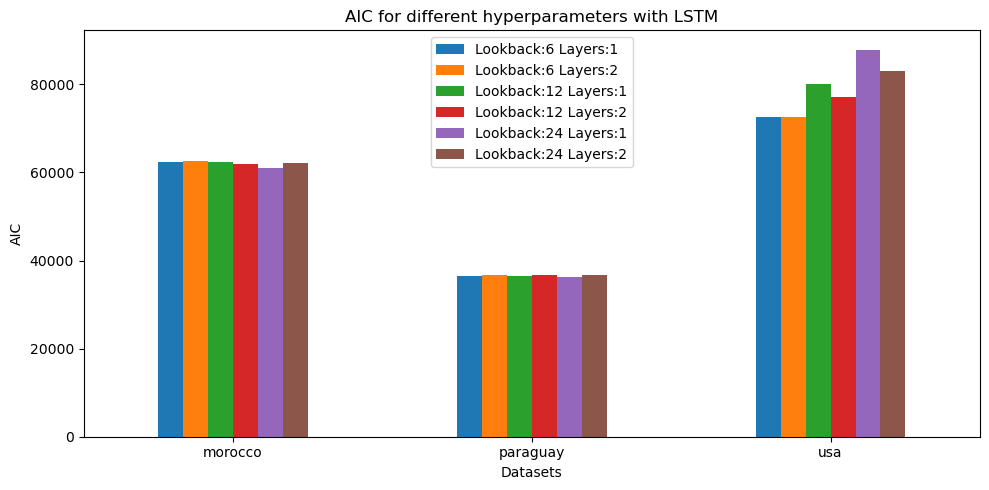

In [104]:
# Plot to get out aic values
#df = pd.DataFrame({key: [item[1] for item in value] for key, value in data.items()}, columns=columns, index=index)
columns = hyperparameter_tuning.keys()
index = ['morocco', 'paraguay', 'usa']
df_aic = pd.DataFrame({key: [item[-2] for item in value] for key, value in hyperparameter_tuning.items()}, columns=columns, index=index)
#df = pd.DataFrame(hyperparameter_tuning, index=[i for i in datasets_electricity.keys()])

df_aic.plot.bar(figsize=(10, 5))
plt.title('AIC for different hyperparameters with LSTM')
#plt.ylim(0, 0.1)
plt.ylabel('AIC')
plt.xlabel('Datasets')
plt.xticks(rotation=0)
#plt.legend(title='Hyperparameters', title_fontsize='13', fontsize='11')
plt.tight_layout()
plt.show()

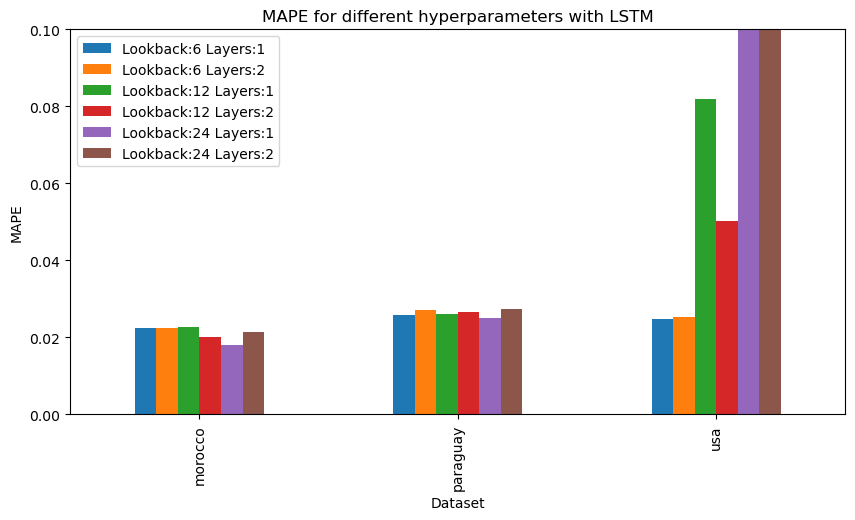

In [95]:
# Plot to get out aic values
#df = pd.DataFrame({key: [item[1] for item in value] for key, value in data.items()}, columns=columns, index=index)
columns = hyperparameter_tuning.keys()
index = ['morocco', 'paraguay', 'usa']
df_aic = pd.DataFrame({key: [item[-3] for item in value] for key, value in hyperparameter_tuning.items()}, columns=columns, index=index)
#df = pd.DataFrame(hyperparameter_tuning, index=[i for i in datasets_electricity.keys()])

df_aic.plot.bar(figsize=(10, 5))
plt.title('MAPE for different hyperparameters with LSTM')
plt.ylim(0, 0.1)
plt.ylabel('MAPE')
plt.xlabel('Dataset')
#plt.legend(title='Hyperparameters', title_fontsize='13', fontsize='11')
plt.show()

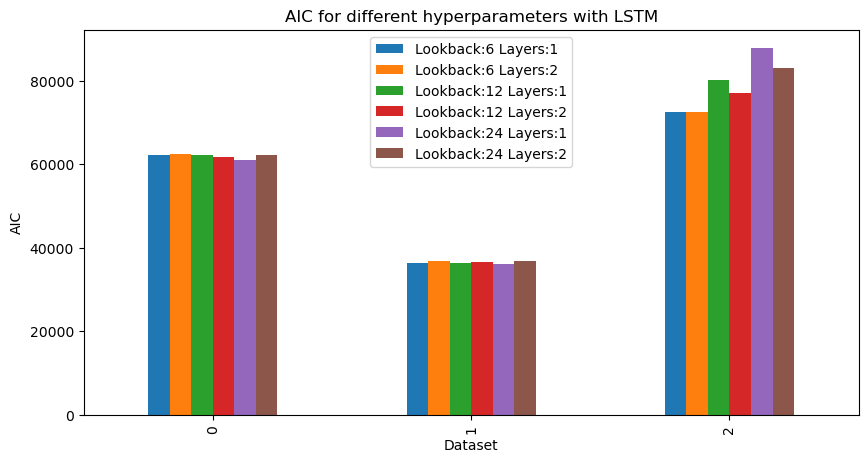

In [94]:
df_tuning_file = pd.read_csv("hyperparameter_tuning_results.csv", header=[0, 1])

# The file might be saved with tuples as column headers for multi-index. Let's handle that:
def eval_tuples(x):
    try:
        return eval(x) if isinstance(x, str) and x.startswith('(') else x
    except:
        return x

# If the headers were saved as strings that represent tuples, convert them back to actual tuples (if necessary)
df_tuning_file.columns = pd.MultiIndex.from_tuples([eval_tuples(col) if isinstance(col, str) else col for col in df_tuning_file.columns])

# Optionally, set the first column as the DataFrame index if it represents your dataset identifiers
#df_tuning_file.set_index(df_tuning_file.columns[0], inplace=True)

df_tuning_file.head()

# Plot the aic values

#df = pd.DataFrame({key: [item[1] for item in value] for key, value in data.items()}, columns=columns, index=index)
#columns = df_tuning_file.keys()
index = ['morocco', 'paraguay', 'usa']
#df_aic = pd.DataFrame({key: [item[-3] for item in value] for key, value in hyperparameter_tuning.items()}, columns=columns, index=index)
#df = pd.DataFrame(hyperparameter_tuning, index=[i for i in datasets_electricity.keys()])
aic_df = df_tuning_file.xs('AIC', level=1, axis=1) 
aic_df.plot.bar(figsize=(10, 5))
plt.title('AIC for different hyperparameters with LSTM')
#plt.ylim(0, 0.1)
plt.ylabel('AIC')
plt.xlabel('Dataset')
#plt.legend(title='Hyperparameters', title_fontsize='13', fontsize='11')
plt.show()

In [120]:
print("\n Autocorrelation 24-steps predicting Consumption")
autocorrelation_24_step = [] # list to store the MAPE results of each dataset
for dataset_name in datasets_electricity:
    start_time = time.time()
    data = add_lagged_timesteps(datasets[dataset_name], lag_periods=[i for i in range(1, 25)], lagged_feature='Consumption').dropna().reset_index(drop=True)
    r2, mae, mape, aic_value, bic_value = lstm_fitting_and_evaluation(data.drop(columns=['DateTime', 'Consumption', 'Temperature']), data['Consumption'], dataset_name, model_file_identifier="autocorrelation24_fully_trained")
    autocorrelation_24_step.append(aic_value)q
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")


 Autocorrelation 24-steps predicting Consumption


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
morocco, MAE: 8456.68, MAPE: 0.023, R2: 0.981
LSTM Model - AIC: 62624.59, BIC: 62789.25
Time taken: 38.40 seconds


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
paraguay, MAE: 147.36, MAPE: 0.026, R2: 0.951
LSTM Model - AIC: 36373.74, BIC: 36515.69
Time taken: 156.89 seconds


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
usa, MAE: 54222.99, MAPE: 0.036, R2: 0.963
LSTM Model - AIC: 74657.39, BIC: 74799.34
Time taken: 176.47 seconds


#### Autocorrelation vs. temperature features


 Lagged temperature + time encodinggs predicting Consumption


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
morocco, MAE: 10539.67, MAPE: 0.028, R2: 0.974
LSTM Model - AIC: 64207.42, BIC: 64814.95
Time taken: 45.21 seconds


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
paraguay, MAE: 163.09, MAPE: 0.029, R2: 0.941
LSTM Model - AIC: 37186.73, BIC: 37771.55
Time taken: 196.71 seconds


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
usa, MAE: 32812.50, MAPE: 0.021, R2: 0.985
LSTM Model - AIC: 71558.51, BIC: 72143.33
Time taken: 215.00 seconds


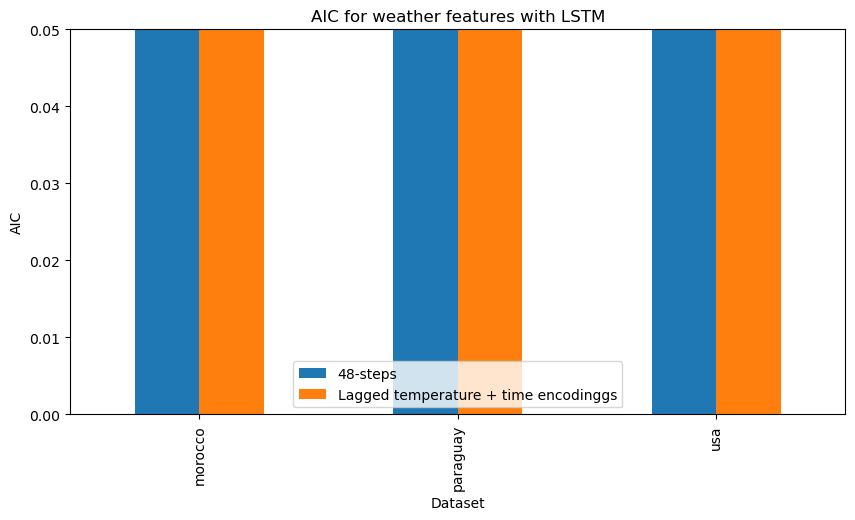

In [113]:
print("\n Autocorrelation 48-steps predicting Consumption")
autocorrelation_48_step = [] # list to store the MAPE results of each dataset
for dataset_name in datasets:
    start_time = time.time()
    data = add_lagged_timesteps(datasets[dataset_name], lag_periods=[i for i in range(1, 49)], lagged_feature='Consumption').dropna().reset_index(drop=True)
    r2, mae, mape, aic_value, bic_value = lstm_fitting_and_evaluation(data.drop(columns=['DateTime', 'Consumption', 'Temperature']), data['Consumption'], dataset_name, model_file_identifier="no_weather")
    autocorrelation_48_step.append(aic_value)
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

print("\n Lagged temperature + time encodinggs predicting Consumption")
lagged_temp_plus_time = [] # list to store the AIC results of each dataset
for dataset_name in datasets:
    start_time = time.time()
    data = add_time_features(datasets[dataset_name])
    data = add_lagged_timesteps(data, lag_periods=[i for i in range(1, 49)], lagged_feature='Consumption')
    data = add_lagged_timesteps(data, lag_periods=[i for i in range(1, 49)], lagged_feature='Temperature').dropna().reset_index(drop=True)
    r2, mae, mape, aic_value, bic_value = lstm_fitting_and_evaluation(data.drop(columns=['DateTime', 'Consumption', 'Temperature']), data['Consumption'], dataset_name, model_file_identifier="weather")
    lagged_temp_plus_time.append(aic_value)
    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.2f} seconds")

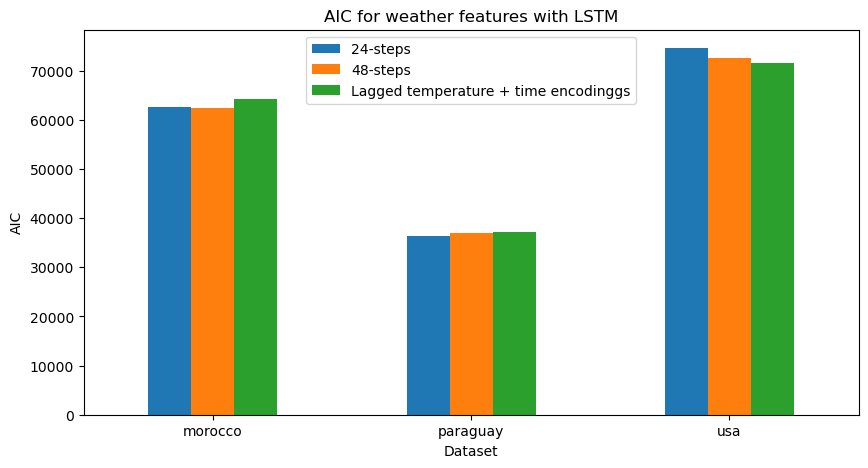

In [124]:
# Create a df to plot the difference between 24-step and 48 step autoreg, with temp
df_24_48_temp = pd.DataFrame({
                    '24-steps': autocorrelation_24_step,
                    '48-steps': autocorrelation_48_step,
                    'Lagged temperature + time encodinggs': lagged_temp_plus_time,
                    },
                    index=[i for i in datasets.keys()])

df_24_48_temp.plot.bar(figsize=(10, 5))
#plt.ylim(30000, 80000)
plt.title('AIC for weather features with LSTM')
plt.ylabel('AIC')
plt.xlabel('Dataset')
plt.xticks(rotation=0)
plt.show()

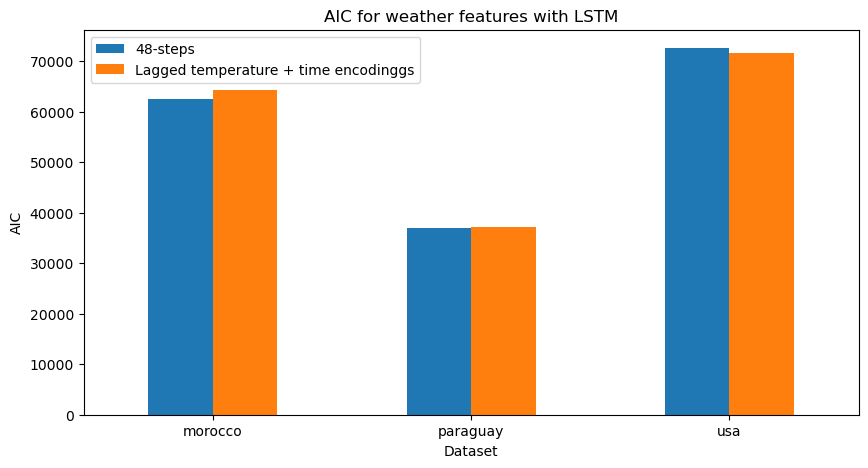

In [116]:
# Use seaborn to plot histogram of the results of the different datasets against each other
#df = pd.DataFrame({'48-steps': autocorrelation_48_step,
#                    'Lagged temperature + time encodinggs': lagged_temp_plus_time,
#                    },
#                    index=[i for i in datasets.keys()])
df.plot.bar(figsize=(10, 5))
#plt.ylim(0, 0.05)
plt.title('AIC for weather features with LSTM')
plt.ylabel('AIC')
plt.xlabel('Dataset')
plt.xticks(rotation=0)
plt.show()

#### LSTM different features
* baseline with the 24 or 48 step autoregression
* conditional volatility?
* moving mean feature
* granger causality feature

In [ ]:
def wrapped_lstm_predictions(x, i):
        data = scaled_X_test[i - lookback:i+1]
        generator = TimeseriesGenerator(data, scaled_y_test[:len(data.reshape(7, -1))], length=n_steps, batch_size=batch)
        predictions = model.predict(generator)
        return predictions


    i = 100
    print(model.predict(generator_test)[i-6:i-5])
    print(scaled_X_test[i - lookback:i+1].shape)
    print(wrapped_lstm_predictions(scaled_X_test, i))
    
    explainer = LimeTabularExplainer(
        scaled_X_train,
        feature_names=features.columns,
        class_names=['Consumption'],
        discretize_continuous=True,
        random_state=0,
        verbose=True, mode='regression'
    )
    
    instance_index = 10  # Choose an index from the test set
    instance = scaled_X_test[instance_index]
    exp = explainer.explain_instance(instance, lambda x: wrapped_lstm_predictions(x, i), num_features=5)
    print(f'Instance {i}:')
    exp.show_in_notebook(show_table=True)

    return r2, mae, mape

print("\n Autocorrelation 48-steps predicting Consumption")
autocorrelation_48_step = [] # list to store the (R2, MAE, MAPE) results of each dataset
for dataset_name in datasets:
    data = add_lagged_timesteps(datasets[dataset_name], lag_periods=[i for i in range(1, 49)], lagged_feature='Consumption').dropna().reset_index(drop=True)
    mape = lstm_fitting_and_evaluation(data.drop(columns=['DateTime', 'Consumption', 'Temperature']), data['Consumption'], dataset_name, model_file_identifier="autocorrelation48_fully_trained")
    autocorrelation_48_step.append(mape)

In [125]:
%%time
#data = morocco.dropna().reset_index(drop=True)
#lookback=48 # 2 days
#n_layers=2
#model_file_identifier = str(lookback) + '_' + str(n_layers)

#mape = fitting_and_eval(data.drop(columns=['Consumption', 'Temperature']), data['Consumption'], 'morocco', model_file_identifier=model_file_identifier, lookback=lookback, n_layers=n_layers)

CPU times: user 8 µs, sys: 11 µs, total: 19 µs
Wall time: 51 µs


### PyTorch implementation
If you prefer not to use TensorFlow for building an LSTM model, another popular choice is PyTorch, a flexible deep learning framework that allows more explicit control over the model architecture and data flow. Here is a basic example of how to implement an LSTM for time series forecasting in PyTorch.

In PyTorch, you define your model as a class that extends nn.Module. Below is a simple example.

Your data should be formatted appropriately for PyTorch, typically as torch.Tensor objects. The input should be of shape (batch size, sequence length, number of features), and the labels should be of a compatible shape, depending on your output.

In [18]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [19]:
import torch
import torch.nn as nn
import numpy as np

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        #

In [ ]:
# out[:, -1, :] just means we are taking the last LSTM output for each sequence
out = self.linear(out[:, -1, :]) 
return out

In [ ]:
# Prepare data
input_dim = 1  # number of features
hidden_dim = 50
num_layers = 2
output_dim = 1

model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, output_dim=output_dim)

# Mean Squared Error Loss
criterion = torch.nn.MSELoss()   

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Training the model involves running the forward pass, calculating the loss, performing backpropagation, and updating the model parameters.

In this code, X_train and y_train should be your training data and labels, respectively, formatted as PyTorch tensors. Ensure that the shapes of your data match the expectations of the model (X_train should have three dimensions: batch, sequence, features).

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  # Clear gradients w.r.t. parameters
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()  # Getting gradients w.r.t. parameters
    optimizer.step()  # Updating parameters
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

### Evaluate
After training, you can use the model to predict on new data. Ensure you format this data similarly to the training data before making predictions.

In [ ]:
model.eval()  # Set the model to evaluation mode
predictions = model(X_test)

Here, X_test should be your test dataset, prepared in the same way as your training dataset.

This example provides a basic introduction to implementing an LSTM in PyTorch for time series forecasting. Depending on your specific problem, you might need to adjust the model architecture, data preprocessing, or training process for optimal results.